In [76]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [77]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [79]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [80]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [81]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [82]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [83]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Inspect the tables

In [84]:
# Set inspector
inspector=inspect(engine)

In [85]:
# Identify datatypes and columns in Measurement Class
columns_measurement=inspector.get_columns('Measurement')
for column in columns_measurement:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [86]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'Most recent date in the data set "Measurement" is: {most_recent_date}')

Most recent date in the data set "Measurement" is: ('2017-08-23',)


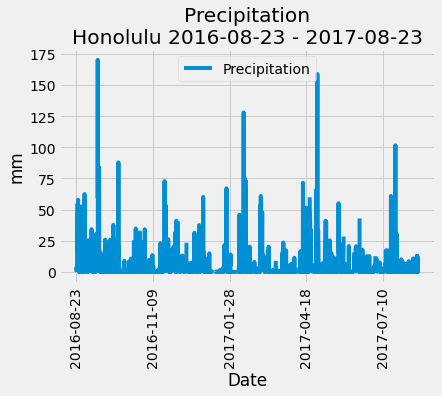

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= query_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_scores, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df_sorted = prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = prcp_df_sorted.plot(title='Precipitation\nHonolulu 2016-08-23 - 2017-08-23')
prcp_plot.set_xlabel("Date")
prcp_plot.set_ylabel("mm")
prcp_plot.legend(["Precipitation"], loc="best")
plt.xticks(rotation=90)
plt.show()


In [88]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df_sorted.describe()

,prcp
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [89]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.station).count()
print(f'Total number of stations in the dataset: {stations}')

Total number of stations in the dataset: 9


In [90]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sta = [Measurement.station, func.count(Measurement.station)]

most_active_stations = session.query(*sta).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [91]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tob = [Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)]
most_active_station_id = most_active_stations[0][0]

data_most_active_station = session.query(*tob).filter(Measurement.station == most_active_station_id).all()

data_most_active_station_df = pd.DataFrame(data_most_active_station, columns=["Station", "Max_Temp", "Min_Temp", "Avg_Temp"])
data_most_active_station_df.set_index('Station')

,Max_Temp,Min_Temp,Avg_Temp
Station,,,
USC00519281,29.4,12.2,22.035823


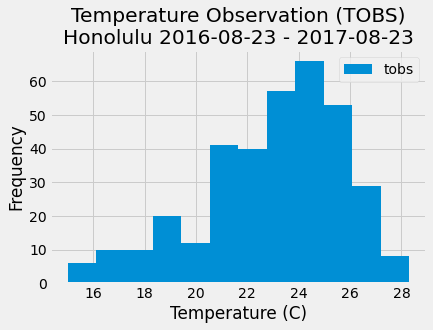

In [92]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_last_year = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= query_date).\
                        filter(Measurement.station == most_active_station_id).all()

tobs_last_year_df = pd.DataFrame(tobs_last_year, columns=['date', 'tobs'])
tobs_last_year_df.set_index('date', inplace=True)

plt.hist(tobs_last_year_df['tobs'], bins=12)
plt.title('Temperature Observation (TOBS)\nHonolulu 2016-08-23 - 2017-08-23')
plt.xlabel('Temperature (C)')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc="best")
plt.show()



# Close session

In [93]:
# Close Session
session.close()